In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from pyearth import Earth
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from patsy import dmatrix
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc, precision_score, recall_score, confusion_matrix

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import SCORERS

#Libraries for visualizing trees
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image

#import pydotplus
import time as tm

import itertools as it

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb

In [91]:
train = pd.read_csv('train.csv')
train

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.97133255718485,High_spent_Large_value_payments,479.866228,Poor
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.18595028760385,High_spent_Medium_value_payments,496.65161,Poor
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.02847744864441,High_spent_Large_value_payments,516.809083,Poor
99998,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.67258219721603,Low_spent_Large_value_payments,319.164979,Standard


# Data quality check / cleaning / preparation¶

### Cleaning - Training Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



# Create Credit Ratings based on Investopedia Values
train['Credit_Rating'] = 0
train['Credit_Rating'] = np.where(train['Credit_Score'] == 'Good',
                          np.random.uniform(670, 730, size=len(train)),
                          train['Credit_Rating'])

train['Credit_Rating'] = np.where(train['Credit_Score'] == 'Standard',
                          np.random.uniform(580, 670, size=len(train)),
                          train['Credit_Rating'])

train['Credit_Rating'] = np.where(train['Credit_Score'] == 'Poor',
                          np.random.uniform(0, 580, size=len(train)),
                          train['Credit_Rating'])



# Drop irrelevant columns
columns_to_drop = ['Customer_ID', 'ID','Month', 'Name', 'SSN', 'Interest_Rate','Occupation',
                    'Type_of_Loan', 'Delay_from_due_date', 'Payment_Behaviour', 'Credit_History_Age', 'Credit_Score']

train.drop(columns_to_drop, axis=1, inplace=True)



# Removing invalid characters from columns
mix_type_num_col = ['Age', 'Annual_Income', 
                    'Num_of_Delayed_Payment','Changed_Credit_Limit',
                    'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance', 'Num_of_Loan']

def set_numeric_columns(features,df=None):

    df[features]=df[features].apply(lambda x: x.replace('_','',regex=True) )
    df[features]=df[features].apply(lambda x: x.str.strip())
    df[features]=df[features].apply(lambda x: x.replace('',np.nan))
    df[features[1:]]=df[features[1:]].astype('float32')
    df[features[0]]=df[features[0]].astype('int32')

set_numeric_columns(mix_type_num_col,df=train)

In [4]:
train = train.dropna()

train = train.loc[train.Credit_Mix != "_"]
train = train.loc[train.Payment_of_Min_Amount != "NM"]

train_dummies = pd.get_dummies(train)

In [5]:
y = train_dummies.Credit_Rating
X = train_dummies.drop(columns = 'Credit_Rating')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

X = X_train[X_train.columns]
y = y_train

# Base Model

In [6]:
model = DecisionTreeRegressor(random_state=1)
model.fit(X, y)

DecisionTreeRegressor(random_state=1)

In [7]:
pred = model.predict(X_test)

In [8]:
print("The RMSE of the Base Model is", np.sqrt(mean_squared_error(y_test, pred)))

The RMSE of the Base Model is 209.9847067897364


# Visualization

In [9]:
# remove outliers

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
def remove_outliers(df, columns, threshold=3):
    print(columns)
    outliers_indices = []
    for column_name in columns:
        # Calculate the Z-scores for the specified column
        z_scores = np.abs((df[column_name] - df[column_name].mean()) / df[column_name].std())
        # Identify outliers based on the threshold
        outliers_indices.extend(z_scores[z_scores > threshold].index)
    
    df_no_outliers = df.drop(outliers_indices)
    return df_no_outliers

train = remove_outliers(train, train.select_dtypes(include = numerics).columns.tolist(), threshold = 1)


['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Rating']


###  Base Model without outliers

In [10]:
train_final = pd.get_dummies(train)
y = train_final.Credit_Rating
X = train_final.drop(columns = 'Credit_Rating')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

X = X_train[X_train.columns]
y = y_train

In [11]:
model = DecisionTreeRegressor(random_state=1)
model.fit(X, y)

DecisionTreeRegressor(random_state=1)

In [12]:
pred = model.predict(X_test)

In [13]:
print("The RMSE of the Base Model is", np.sqrt(mean_squared_error(y_test, pred)))

The RMSE of the Base Model is 90.01351416029347


### distribution of the response variable

<AxesSubplot:xlabel='Credit_Rating', ylabel='Density'>

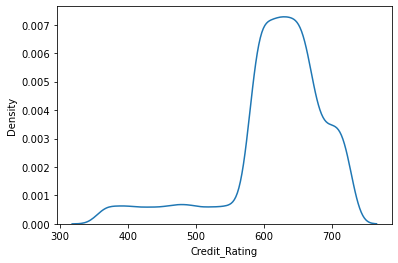

In [14]:
sns.kdeplot(train_final.Credit_Rating)

### distribution of each predictor

#### continuous

In [90]:
train_dummies

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Rating,Credit_Mix_Bad,Credit_Mix_Good,Credit_Mix_Standard,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes
6,23,19114.119141,1824.843333,3,4,4.0,8.0,11.27,4.0,809.979980,22.537593,49.574949,178.344070,244.565323,676.420317,0,1,0,1,0
7,23,19114.119141,1824.843333,3,4,4.0,6.0,11.27,4.0,809.979980,23.933795,49.574949,24.785217,358.124176,621.114156,0,1,0,1,0
8,28,34847.839844,3037.986667,2,4,1.0,4.0,5.42,2.0,605.030029,24.464031,18.816215,104.291824,470.690613,620.045172,0,1,0,1,0
9,28,34847.839844,3037.986667,2,4,1.0,1.0,7.42,2.0,605.030029,38.550848,18.816215,40.391239,484.591217,670.427998,0,1,0,1,0
12,28,34847.839844,3037.986667,2,4,1.0,1.0,6.42,2.0,605.030029,34.977895,18.816215,130.115417,444.867035,688.698591,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98293,29,34599.941406,2942.328333,7,699,0.0,9.0,-3.55,1.0,942.590027,32.375813,0.000000,10000.000000,476.269745,646.942797,0,0,1,1,0
98295,29,34599.941406,2942.328333,7,6,0.0,8.0,3.45,1.0,942.590027,33.128609,0.000000,165.397552,388.835297,604.130188,0,0,1,1,0
98300,38,41015.550781,3152.962500,1194,4,1.0,1.0,1.58,2.0,599.400024,26.268474,25.671257,76.057220,453.567780,659.350779,0,1,0,1,0
98301,38,41015.550781,3152.962500,0,4,1.0,1.0,1.58,2.0,599.400024,28.754729,25.671257,91.198586,448.426392,635.283135,0,1,0,1,0


In [16]:
train_final.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Rating,Credit_Mix_Bad,Credit_Mix_Good,Credit_Mix_Standard,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes
12,28,34847.839844,3037.986667,2,4,1.0,1.0,6.42,2.0,605.030029,34.977895,18.816215,130.115417,444.867035,688.698591,0,1,0,1,0
13,28,34847.839844,3037.986667,2,4,1.0,0.0,5.42,2.0,605.030029,33.381010,18.816215,43.477192,481.505249,690.209394,0,1,0,1,0
15,28,34847.839844,3037.986667,2,4,1.0,4.0,5.42,2.0,605.030029,32.933856,18.816215,218.904343,356.078094,723.831427,0,1,0,1,0
81,40,33751.269531,2948.605833,5,5,3.0,20.0,11.00,4.0,1328.930054,30.908081,65.008174,70.131081,399.721344,643.980872,0,0,1,0,1
84,40,33751.269531,2948.605833,5,5,3.0,20.0,8.00,8.0,1328.930054,29.073758,65.008174,243.329681,276.522736,585.880859,0,0,1,0,1


<AxesSubplot:xlabel='Age', ylabel='Density'>

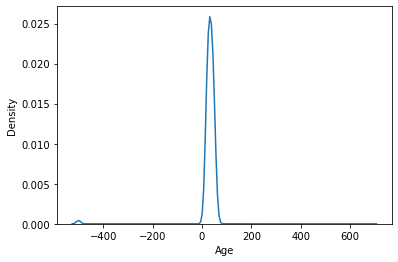

In [17]:
sns.kdeplot(train_final.Age)

<AxesSubplot:xlabel='Annual_Income', ylabel='Density'>

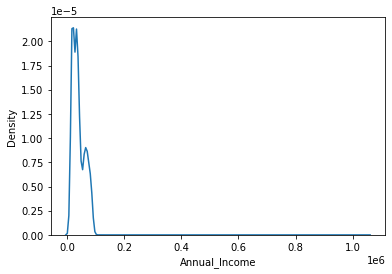

In [18]:
sns.kdeplot(train_final.Annual_Income)

<AxesSubplot:xlabel='Monthly_Inhand_Salary', ylabel='Density'>

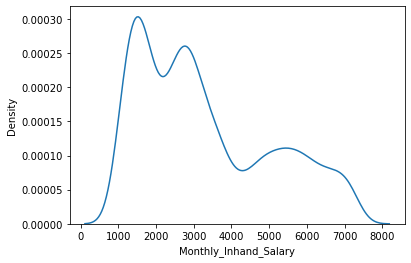

In [19]:
sns.kdeplot(train_final.Monthly_Inhand_Salary)

<AxesSubplot:xlabel='Num_Bank_Accounts', ylabel='Density'>

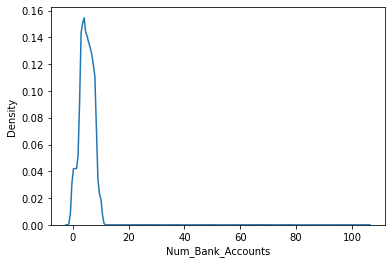

In [20]:
sns.kdeplot(train_final.Num_Bank_Accounts)

<AxesSubplot:xlabel='Num_Credit_Card', ylabel='Density'>

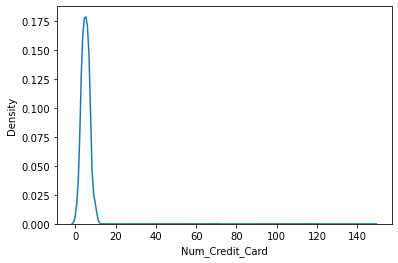

In [21]:
sns.kdeplot(train_final.Num_Credit_Card)

<AxesSubplot:xlabel='Num_of_Loan', ylabel='Density'>

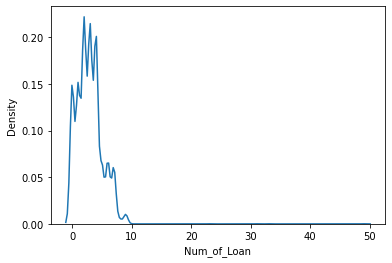

In [22]:
sns.kdeplot(train_final.Num_of_Loan)

<AxesSubplot:xlabel='Num_of_Delayed_Payment', ylabel='Density'>

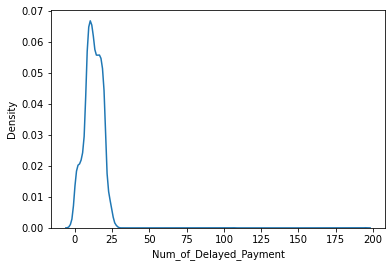

In [23]:
sns.kdeplot(train_final.Num_of_Delayed_Payment)

<AxesSubplot:xlabel='Changed_Credit_Limit', ylabel='Density'>

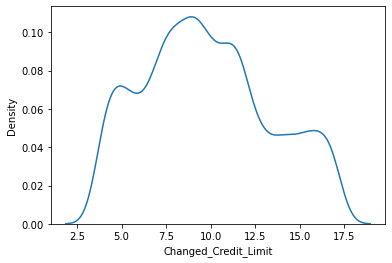

In [24]:
sns.kdeplot(train_final.Changed_Credit_Limit)

<AxesSubplot:xlabel='Num_Credit_Inquiries', ylabel='Density'>

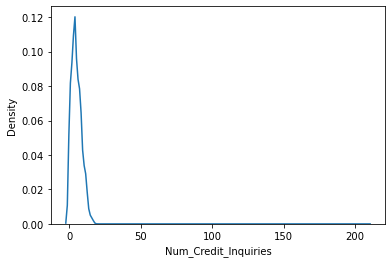

In [25]:
sns.kdeplot(train_final.Num_Credit_Inquiries)

<AxesSubplot:xlabel='Outstanding_Debt', ylabel='Density'>

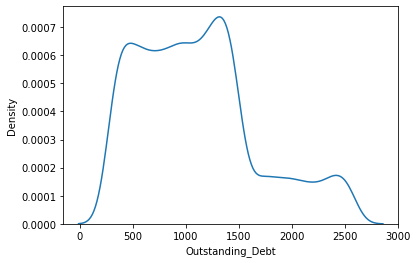

In [26]:
sns.kdeplot(train_final.Outstanding_Debt)

<AxesSubplot:xlabel='Credit_Utilization_Ratio', ylabel='Density'>

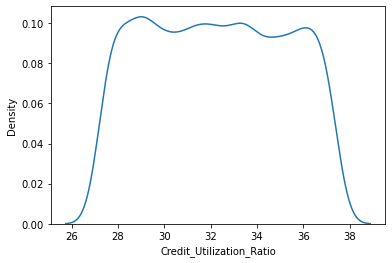

In [27]:
sns.kdeplot(train_final.Credit_Utilization_Ratio)

<AxesSubplot:xlabel='Total_EMI_per_month', ylabel='Density'>

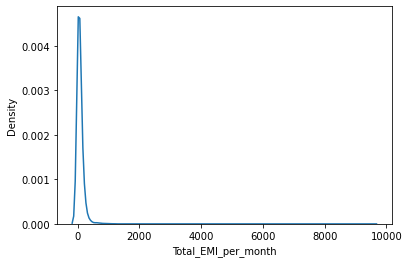

In [28]:
sns.kdeplot(train_final.Total_EMI_per_month)

<AxesSubplot:xlabel='Amount_invested_monthly', ylabel='Density'>

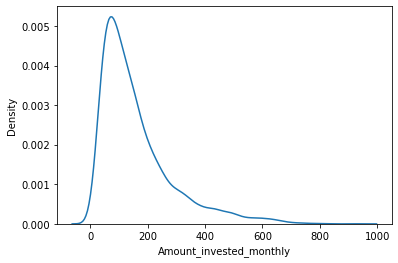

In [29]:
sns.kdeplot(train_final.Amount_invested_monthly)

<AxesSubplot:xlabel='Monthly_Balance', ylabel='Density'>

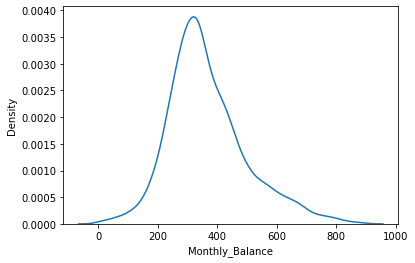

In [30]:
sns.kdeplot(train_final.Monthly_Balance)

<AxesSubplot:xlabel='Credit_Rating', ylabel='Density'>

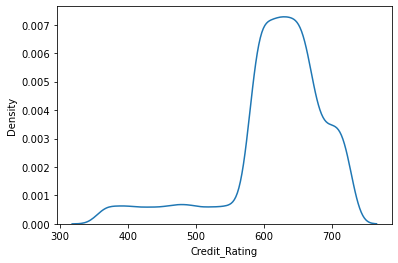

In [31]:
sns.kdeplot(train_final.Credit_Rating)

#### categorical

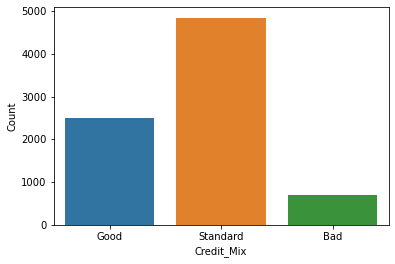

In [32]:
# Credit_Mix
sns.countplot(x='Credit_Mix', data = train)
plt.xlabel('Credit_Mix')
plt.ylabel('Count')

plt.show()

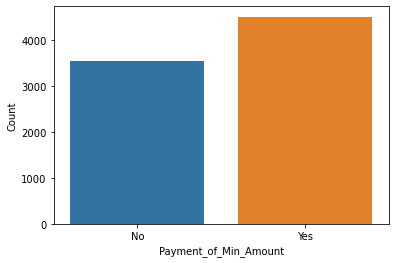

In [33]:
# Payment of Min Amount 
sns.countplot(x='Payment_of_Min_Amount', data = train)
plt.xlabel('Payment_of_Min_Amount')
plt.ylabel('Count')

plt.show()

# TRAIN DATASET IS CALLED train_final*******

In [34]:
train_final = pd.get_dummies(train)
y = train_final.Credit_Rating
X = train_final.drop(columns = 'Credit_Rating')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

X = X_train[X_train.columns]
y = y_train

## MARS - Luca

In [35]:
rmse_df = pd.DataFrame(columns = {'degree', 'RMSE'})
cv = KFold(n_splits=5, random_state=1, shuffle=True)
counter = 0
for degree in np.arange(1, 10, 1):
    rmse_df.loc[counter, 'RMSE'] = np.sqrt(np.mean(-cross_val_score(Earth(max_terms=1000, max_degree = degree),
                                 X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
    rmse_df.loc[counter, 'degree'] = degree
    counter = counter + 1

/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warn

/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this war

/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the 

/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this war

/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [36]:
rmse_df.loc[np.argmin(rmse_df.RMSE),:]

degree            2
RMSE      64.582452
Name: 1, dtype: object

In [37]:
model = Earth(max_terms=1000, max_degree=5, feature_importance_type= 'rss') 
model.fit(X_train,y_train)
print(model.summary())

Earth Model
----------------------------------------------------------------------------------------------------------------------------------------
Basis Function                                                                                                    Pruned  Coefficient   
----------------------------------------------------------------------------------------------------------------------------------------
(Intercept)                                                                                                       No      618.346       
h(Outstanding_Debt-1404.99)                                                                                       Yes     None          
h(1404.99-Outstanding_Debt)                                                                                       No      0.0640988     
Credit_Mix_Good                                                                                                   No      18.4747       
Credit_Mix_Bad               

In [38]:
pd.concat([pd.Series(X.columns, name = 'predictor'), 
           pd.Series(model.feature_importances_, 
                     name = 'importance')], axis = 1).sort_values(by = 'importance', ascending=False)[0:6]

,predictor,importance
14,Credit_Mix_Bad,0.325127
9,Outstanding_Debt,0.232430
16,Credit_Mix_Standard,0.176854
15,Credit_Mix_Good,0.096496
8,Num_Credit_Inquiries,0.064419
11,Total_EMI_per_month,0.038698


## Bagging - Nicket

### grid search

In [39]:
n_samples = train.shape[0]
n_features = train.shape[1]

params = {'base_estimator': [DecisionTreeRegressor(random_state = 1),LinearRegression()],#Comparing bagging with a linear regression model as well
          'n_estimators': [150,200,250],
          'max_samples': [0.5,1.0],
          'max_features': [0.5,1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_regressor_grid = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1)
bagging_regressor_grid.fit(X, y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=BaggingRegressor(n_jobs=-1, random_state=1), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeRegressor(random_state=1),
                                            LinearRegression()],
                         'bootstrap': [True, False],
                         'bootstrap_features': [True, False],
                         'max_features': [0.5, 1.0], 'max_samples': [0.5, 1.0],
                         'n_estimators': [150, 200, 250]},
             verbose=1)

In [40]:
print('Best Parameters : ',bagging_regressor_grid.best_params_)

Best Parameters :  {'base_estimator': DecisionTreeRegressor(random_state=1), 'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 250}


In [41]:
#Model with optimal parameters
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=250, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=True,bootstrap=True,
                        max_features=1.0,max_samples=1.0).fit(X, y)

#RMSE on test data
RMSE = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print(RMSE)


64.35436111810004


### finer grid search 1

In [42]:
n_samples = train.shape[0]
n_features = train.shape[1]

finer_params1 = {'base_estimator': [DecisionTreeRegressor(random_state = 1),LinearRegression()],#Comparing bagging with a linear regression model as well
          'n_estimators': [250, 300, 350],
          'max_samples': [1.0, 1.5],
          'max_features': [1.0, 1.5],
          'bootstrap': [True],
          'bootstrap_features': [True]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_regressor_grid_finer1 = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =finer_params1, cv=cv, n_jobs=-1, verbose=1)
bagging_regressor_grid_finer1.fit(X, y)

print('Best Parameters : ',bagging_regressor_grid_finer1.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters :  {'base_estimator': DecisionTreeRegressor(random_state=1), 'bootstrap': True, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 250}


In [43]:
#Model with optimal parameters
model_finer1 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=250, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=True,bootstrap=True,
                        max_features=1.0,max_samples=1.0).fit(X, y)

#RMSE on test data
RMSE = np.sqrt(mean_squared_error(y_test, model_finer1.predict(X_test)))
print(RMSE)


64.35436111810004


### finer grid search 2

In [44]:
n_samples = train.shape[0]
n_features = train.shape[1]

finer_params2 = {'base_estimator': [DecisionTreeRegressor(random_state = 1),LinearRegression()],#Comparing bagging with a linear regression model as well
          'n_estimators': [250, 300, 350],
          'max_samples': [.75, 1.0, 1.25],
          'max_features': [.75, 1.0, 1.25],
          'bootstrap': [True],
          'bootstrap_features': [True]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_regressor_grid_finer2 = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =finer_params2, cv=cv, n_jobs=-1, verbose=1)
bagging_regressor_grid_finer2.fit(X_train, y_train)

print('Best Parameters : ',bagging_regressor_grid_finer1.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters :  {'base_estimator': DecisionTreeRegressor(random_state=1), 'bootstrap': True, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 250}


In [45]:
#Model with optimal parameters
model_finer2 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=300, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=True,bootstrap=True,
                        max_features=1.0,max_samples=1.0).fit(X, y)

#RMSE on test data
RMSE = np.sqrt(mean_squared_error(y_test, model_finer2.predict(X_test)))
print(RMSE)


64.34187345036374


## Random Forest - Kaylee

In [46]:
rmse = {}

for i in np.linspace(10, 500, 40,dtype=int):
    model = RandomForestRegressor(n_estimators=i, random_state=1,
                        n_jobs=-1, oob_score=True).fit(X, y)
    pred = model.predict(X_test)
    rmse[i] = np.sqrt(mean_squared_error(y_test, pred))

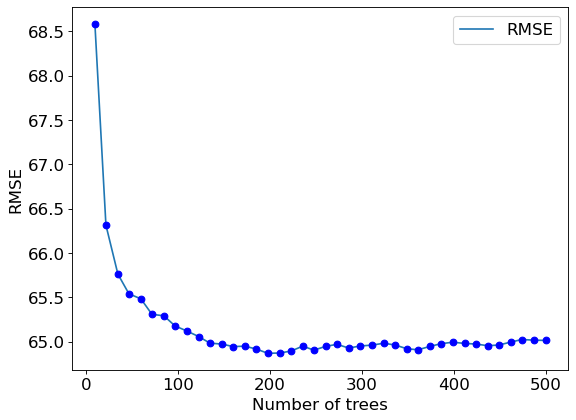

In [47]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(rmse.keys(),rmse.values(),label = 'RMSE')
plt.plot(rmse.keys(),rmse.values(),'o', color = 'blue')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()

### course grid

In [48]:
# seems to slow down between 400 and 500

n_samples = train_final.shape[0]
n_features = train_final.shape[1]

params = {'max_depth': [12,15,18],
          'max_leaf_nodes':[1100,1200,1300],
          'max_features': list(range(1,20))}

param_list=list(it.product(*(params[Name] for Name in params)))

oob_score = [0]*len(param_list)

i=0
for pr in param_list:
    model = RandomForestRegressor(random_state = 1, oob_score = True,
                                  verbose = False, n_estimators = 450,
                                  max_depth = pr[0],
                                  max_leaf_nodes = pr[1], 
                                  max_features = pr[2],
                                  n_jobs = -1).fit(X, y)
    oob_score[i] = model.oob_score_
    i=i+1
    

print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

Best params =  (18, 1300, 3)
Best score (R-squared) =  0.31681396219539104


In [49]:
model_rf = RandomForestRegressor(random_state = 1,
                                n_estimators = 450,
                                max_depth = 18,
                                max_leaf_nodes = 1300,
                                max_features = 3,
                                n_jobs = -1)

model_rf.fit(X, y)

pred_rf = model_rf.predict(X_test)

print("The RMSE on test data is", np.sqrt(mean_squared_error(y_test, pred_rf)))

The RMSE on test data is 64.25555802591421


### finer grid 1

In [50]:
n_samples = train_final.shape[0]
n_features = train_final.shape[1]

params = {'max_depth': range(15, 25, 3),
          'max_leaf_nodes':range(1300, 1600, 100),
          'max_features': list(range(1,5))}

param_list=list(it.product(*(params[Name] for Name in params)))

oob_score = [0]*len(param_list)

i=0
for pr in param_list:
    model = RandomForestRegressor(random_state = 1, oob_score = True,
                                  verbose = False, n_estimators = 450,
                                  max_depth = pr[0],
                                  max_leaf_nodes = pr[1], 
                                  max_features = pr[2],
                                  n_jobs = -1).fit(X, y)
    oob_score[i] = model.oob_score_
    i=i+1
    

print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

Best params =  (24, 1300, 4)
Best score (R-squared) =  0.3193641508762848


In [51]:
model_rf2 = RandomForestRegressor(random_state = 1,
                                n_estimators = 450,
                                max_depth = 21,
                                max_leaf_nodes = 1400,
                                max_features = 3,
                                n_jobs = -1)

model_rf2.fit(X, y)

pred_rf2 = model_rf2.predict(X_test)

print("The RMSE on test data is", np.sqrt(mean_squared_error(y_test, pred_rf2)))

The RMSE on test data is 64.20969742972815


### finer grid 2

In [52]:
params = {'max_depth': range(15, 25, 3),
          'max_leaf_nodes':range(1300, 1600, 100),
          'max_features': list(range(1,5)),
          'bootstrap': [True, False]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)


rf = RandomForestRegressor(n_estimators = 450, random_state = 1)


grid_search = GridSearchCV(rf, 
                           params, 
                           cv = cv, 
                           n_jobs = -1, 
                           verbose = 1,
                           scoring='neg_mean_absolute_error')


grid_search.fit(X_train, y_train)



print (grid_search.best_score_, grid_search.best_params_) 

Fitting 5 folds for each of 96 candidates, totalling 480 fits
-44.51740722531566 {'bootstrap': False, 'max_depth': 24, 'max_features': 2, 'max_leaf_nodes': 1400}


In [53]:
model_rf_final = RandomForestRegressor(random_state = 1,
                                n_estimators = 450,
                                max_depth = 24,
                                max_leaf_nodes = 1500,
                                max_features = 2,
                                bootstrap = False,
                                n_jobs = -1)

model_rf_final.fit(X, y)

pred_rf_final = model_rf_final.predict(X_test)

print("The RMSE on test data is", np.sqrt(mean_squared_error(y_test, pred_rf_final)))

The RMSE on test data is 64.00245466003211


## XG Boost - Ashley

In [54]:
import warnings
warnings.filterwarnings("ignore")

### course grid

In [55]:
#K-fold cross validation to find optimal parameters for XGBoost
start_time = time.time()
param_grid = {'max_depth': [4,6,8],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 1, 10],
                'n_estimators':[100, 500, 1000],
                'gamma': [0, 10, 100],
                'subsample': [0.5, 0.75, 1.0],
                'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 1.0, 'reg_lambda': 0, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.5}
Optimal cross validation R-squared =  0.30123677358989553
Time taken =  8  minutes


In [56]:
means = optimal_params.cv_results_['mean_test_score']
stds = optimal_params.cv_results_['std_test_score']
params = optimal_params.cv_results_['params']

In [57]:
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(X_test),y_test))

64.9367793842193

### visualization

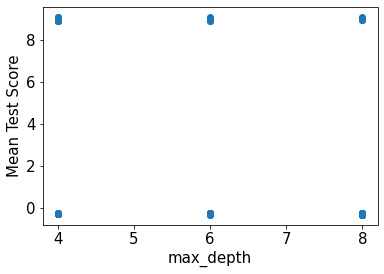

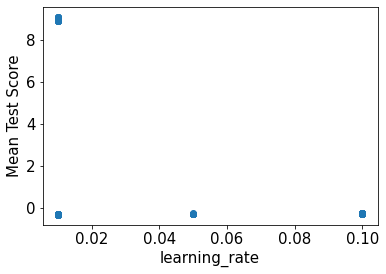

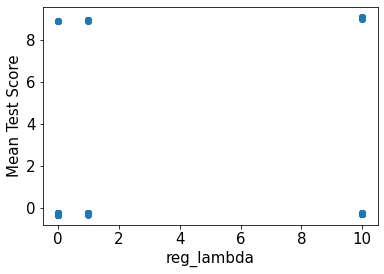

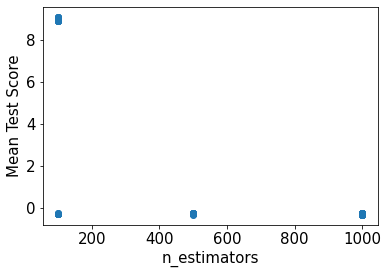

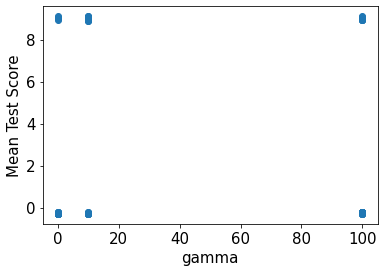

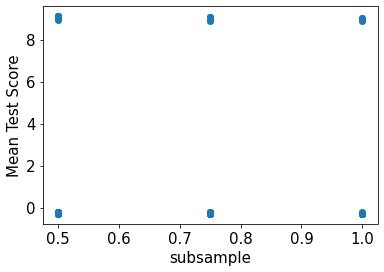

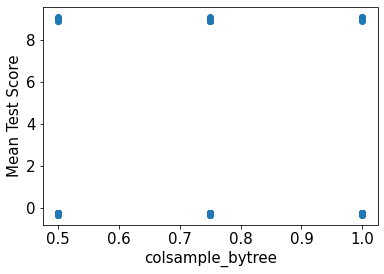

In [58]:
param_names = ['max_depth','learning_rate','reg_lambda','n_estimators','gamma','subsample','colsample_bytree']

for i in range(len(param_names)):
    values = []
    for j in range(len(params)):
        values.append(params[j][param_names[i]])    
    fig, ax = plt.subplots()
    ax.scatter(values, -means)
    ax.set_xlabel(param_names[i])
    ax.set_ylabel('Mean Test Score')    
    plt.show()

### finer grid 1

In [59]:
start_time = time.time()
param_grid = {'max_depth': [5,6,7],
              'learning_rate': [0.01,0.011],
               'reg_lambda':[0.4,1,1.5],
                'n_estimators':[1000, 2000, 3000],
                'gamma': [50,100],
                'subsample': [0.45,0.5,0.55],
                'colsample_bytree': [0.4,0.5]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,n_jobs=-1,cv=cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 2 folds for each of 200 candidates, totalling 400 fits
Optimal parameter values = {'subsample': 0.55, 'reg_lambda': 1, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 100, 'colsample_bytree': 0.4}
Optimal cross validation R-squared =  0.2721425072160432
Time taken =  6  minutes


In [60]:
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(X_test),y_test))

65.10111807286758

### finer grid 2

In [61]:
start_time = time.time()
param_grid = {'max_depth': [7],
              'learning_rate': [0.01,0.0088],
               'reg_lambda':[0.4],
                'n_estimators':[1000,1500,1650],
                'gamma': [15,50],
                'subsample': [0.5,0.55],
                'colsample_bytree': [0.4]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,n_jobs=-1,cv=cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 2 folds for each of 24 candidates, totalling 48 fits
Optimal parameter values = {'subsample': 0.55, 'reg_lambda': 0.4, 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.0088, 'gamma': 50, 'colsample_bytree': 0.4}
Optimal cross validation R-squared =  0.27226024723464154
Time taken =  1  minutes


In [62]:
## hopefully this gives the params below bc it gives the lowest rmse out of everything i've tried 

model = xgb.XGBRegressor(random_state=1,
                         subsample=0.5,
                         reg_lambda=0.4,
                         n_estimators=1650,
                         max_depth=7,
                         learning_rate=0.0088,
                         gamma=15,
                         colsample_bytree=0.4).fit(X_train,y_train)

np.sqrt(mean_squared_error(model.predict(X_test),y_test))

64.65756729881915

### change n_estimators

In [63]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.55,
                         reg_lambda=0.4,
                         n_estimators=1500,
                         max_depth=7,
                         learning_rate=0.01,
                         gamma=50,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [64]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

64.55279590600612

### change gamma

In [65]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.55,
                         reg_lambda=0.4,
                         n_estimators=1700,
                         max_depth=7,
                         learning_rate=0.01,
                         gamma=50,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [66]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

64.53584079617286

In [67]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.55,
                         reg_lambda=0.4,
                         n_estimators=1700,
                         max_depth=7,
                         learning_rate=0.01,
                         gamma=10,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [68]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

64.59734195180457

In [69]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.55,
                         reg_lambda=0.4,
                         n_estimators=1700,
                         max_depth=7,
                         learning_rate=0.01,
                         gamma=15,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [70]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

64.62580108845869

### change subsample

In [71]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.5,
                         reg_lambda=0.4,
                         n_estimators=1700,
                         max_depth=7,
                         learning_rate=0.01,
                         gamma=15,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [72]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

64.76325992391975

### change learning_rate

In [73]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.5,
                         reg_lambda=0.4,
                         n_estimators=1700,
                         max_depth=7,
                         learning_rate=0.0088,
                         gamma=15,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [74]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

64.66527109603983

# FINAL MODELS

#### MARS

In [75]:
MARS_model = Earth(max_terms=1000, max_degree=5, feature_importance_type= 'rss').fit(X, y)
print(MARS_model.summary())

Earth Model
----------------------------------------------------------------------------------------------------------------------------------------
Basis Function                                                                                                    Pruned  Coefficient   
----------------------------------------------------------------------------------------------------------------------------------------
(Intercept)                                                                                                       No      618.346       
h(Outstanding_Debt-1404.99)                                                                                       Yes     None          
h(1404.99-Outstanding_Debt)                                                                                       No      0.0640988     
Credit_Mix_Good                                                                                                   No      18.4747       
Credit_Mix_Bad               

In [76]:
np.sqrt(mean_squared_error(y_test, MARS_model.predict(X_test)))

67.1635761715528

In [77]:
pd.concat([pd.Series(X.columns, name = 'predictor'), 
           pd.Series(MARS_model.feature_importances_, 
                     name = 'importance')], axis = 1).sort_values(by = 'importance', ascending=False)[0:6]

,predictor,importance
14,Credit_Mix_Bad,0.325127
9,Outstanding_Debt,0.232430
16,Credit_Mix_Standard,0.176854
15,Credit_Mix_Good,0.096496
8,Num_Credit_Inquiries,0.064419
11,Total_EMI_per_month,0.038698


#### BAGGING

In [78]:
bagging_model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=300, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=True,bootstrap=True,
                        max_features=1.0,max_samples=1.0).fit(X, y)

RMSE = np.sqrt(mean_squared_error(y_test, bagging_model.predict(X_test)))
print(RMSE)

64.34187345036374


In [79]:
predictors = np.array(X.columns)

feature_importances = np.mean([
    tree.feature_importances_ for tree in bagging_model.estimators_
], axis=0)

importances = pd.DataFrame(columns = {'predictors', 'importance'})

importances['predictors'] = pd.Series(predictors)
importances['importance'] = pd.Series(feature_importances)

importances.sort_values(by = "importance", ascending = False)

,importance,predictors
4,0.057266,Num_Credit_Card
13,0.056880,Monthly_Balance
17,0.056226,Payment_of_Min_Amount_No
1,0.055651,Annual_Income
0,0.055573,Age
16,0.053775,Credit_Mix_Standard
15,0.053635,Credit_Mix_Good
9,0.052721,Outstanding_Debt
3,0.052572,Num_Bank_Accounts
7,0.052388,Changed_Credit_Limit


#### RANDOM FOREST 

In [80]:
rf_model = RandomForestRegressor(random_state = 1,
                                n_estimators = 450,
                                max_depth = 24,
                                max_leaf_nodes = 1500,
                                max_features = 2,
                                bootstrap = False,
                                n_jobs = -1)
rf_model.fit(X, y)

pred_rf_final = rf_model.predict(X_test)

print("The RMSE on test data is", np.sqrt(mean_squared_error(y_test, pred_rf_final)))

The RMSE on test data is 64.00245466003211


In [81]:
predictors = np.array(X.columns)

feature_importances = np.mean([
    tree.feature_importances_ for tree in rf_model.estimators_
], axis=0)

importances = pd.DataFrame(columns = {'predictors', 'importance'})

importances['predictors'] = pd.Series(predictors)
importances['importance'] = pd.Series(feature_importances)

importances.sort_values(by = "importance", ascending = False)

,importance,predictors
9,0.127434,Outstanding_Debt
8,0.071607,Num_Credit_Inquiries
13,0.061675,Monthly_Balance
12,0.061279,Amount_invested_monthly
10,0.060297,Credit_Utilization_Ratio
7,0.060050,Changed_Credit_Limit
4,0.057588,Num_Credit_Card
11,0.057382,Total_EMI_per_month
2,0.055895,Monthly_Inhand_Salary
1,0.055772,Annual_Income


#### XGBOOST

In [85]:
xgb_model = xgb.XGBRegressor(random_state=1,
                         subsample=0.5,
                         reg_lambda=0.4,
                         n_estimators=1650,
                         max_depth=7,
                         learning_rate=0.0088,
                         gamma=15,
                         colsample_bytree=0.4).fit(X_train,y_train)

np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test)))

64.65756729881915

In [86]:
predictors = np.array(X.columns)

feature_importances = xgb_model.feature_importances_

importances = pd.DataFrame(columns = {'predictors', 'importance'})

importances['predictors'] = pd.Series(predictors)
importances['importance'] = pd.Series(feature_importances)

importances.sort_values(by = "importance", ascending = False)

,importance,predictors
14,0.174196,Credit_Mix_Bad
18,0.135447,Payment_of_Min_Amount_Yes
17,0.121012,Payment_of_Min_Amount_No
15,0.114025,Credit_Mix_Good
16,0.068757,Credit_Mix_Standard
9,0.054767,Outstanding_Debt
8,0.040338,Num_Credit_Inquiries
11,0.029147,Total_EMI_per_month
4,0.027678,Num_Credit_Card
12,0.027014,Amount_invested_monthly


## Ensemble Model

#### STACKING

In [87]:
#LinearRegression as the metamodel

final_model = StackingRegressor(estimators = [('xgb', xgb_model),('rf', rf_model), 
                                              ('bagging', bagging_model), ('MARS', MARS_model)],
                                final_estimator=LinearRegression(),                                          
                                cv = KFold(n_splits = 5, shuffle = True, random_state=1))

final_model.fit(X,y)

print("The Final Model RMSE  is ", np.sqrt(mean_squared_error(final_model.predict(X_test), y_test)))

The Final Model RMSE  is  63.9805813425645


In [88]:
#Co-efficients 
final_model.final_estimator_.coef_

array([ 6.83735088e-02,  6.85745638e-01,  2.67830286e-01, -9.90036928e-05])

#### VOTING

In [94]:
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier


#Voting ensemble: Averaging the predictions of all models
en = VotingRegressor(estimators = [('xgb', xgb_model),('rf', rf_model), 
                                              ('bagging', bagging_model), ('MARS', MARS_model)])
en.fit(X,y)
print("Ensemble model RMSE = ", np.sqrt(mean_squared_error(en.predict(X_test),y_test)))

Ensemble model RMSE =  64.31496677604076
